In [8]:
import sklearn as sk
from imblearn.over_sampling import SMOTENC
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import  roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from xgboost.sklearn import XGBClassifier

In [2]:
dat = pd.read_csv('C:/Users/seanm/OneDrive/Documents/voting_data.csv')
y = dat['voted']
X = dat.drop('voted', axis = 1)
pca_x = X.iloc[:,1:-4 ]
qual_x = X.iloc[:, -4:-1]

In [3]:
pca = PCA(n_components= 6)
X_reduced = pca.fit_transform(pca_x)
pca.explained_variance_ratio_
X_projected = pd.DataFrame(X_reduced)
#X_projected['ideology'] = X['ideology']
X_projected['Gender'] = qual_x['gender_baseline']
X_projected['Race'] = qual_x['race_baseline']
X_projected['Education'] = qual_x['educ_baseline']
X_projected

,0,1,2,3,4,5,Gender,Race,Education
0,-0.250264,1.203283,-2.480412,-3.603004,-0.026872,-1.871207,2,1,5
1,-2.403204,-1.247470,-0.781840,-1.296683,1.161747,-0.968145,2,1,3
2,-3.530089,0.826730,1.624370,0.517767,0.819070,-0.077007,1,1,2
3,-0.617937,0.454679,-0.128582,-0.650438,0.835403,-1.356756,1,1,3
4,-3.960786,-0.201996,-0.932215,-0.461775,-0.019467,-0.187567,1,1,5
...,...,...,...,...,...,...,...,...,...
7773,-2.813169,-3.228442,2.209270,-0.470302,-3.189698,-0.219418,2,2,2
7774,-2.369579,0.615680,0.470213,-0.831498,-0.719010,-0.158574,2,1,3
7775,-2.889763,-4.086254,1.604399,-0.363529,-3.225472,0.470117,2,1,2
7776,-2.150269,3.912656,3.487388,0.277196,-0.446076,0.093654,1,1,3


In [4]:
#X_resampled, y_resampled = SMOTENC(categorical_features= [53,54,55]).fit_resample(X,y)
X_resampled, y_resampled = SMOTENC(categorical_features= [6,7,8]).fit_resample(X_projected,y)

In [5]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X_resampled,y_resampled, test_size= .25, random_state= 123)

In [62]:
tree_vote = DecisionTreeClassifier(max_depth= 5)
tree_vote.fit(X_train,y_train)
y_preds = tree_vote.predict(X_test)
sk.metrics.confusion_matrix(y_test,y_preds)

array([[1372,  491],
       [ 778, 1082]], dtype=int64)

In [64]:
y_preds = tree_vote.predict(X_projected)
sk.metrics.confusion_matrix(y,y_preds)

array([[ 229,  103],
       [3032, 4414]], dtype=int64)

In [66]:
pd.DataFrame(tree_vote.feature_importances_, X_projected.columns)

,0
0,0.089031
1,0.042574
2,0.005515
3,0.034382
4,0.091541
5,0.081114
Gender,0.082237
Race,0.159855
Education,0.413752


In [23]:
log =sk.linear_model.LogisticRegression( max_iter = 1000)
params = {'C': [1.0,100.0]}
grid_log = GridSearchCV(log, params, cv = 5)
grid_log.fit(X_train, y_train)
log_C = grid_log.best_params_['C']


In [24]:
tree = DecisionTreeClassifier()
params = {'max_depth': [3,4,5,6,7,8,9,10]}
grid_tree = GridSearchCV(tree, params, cv = 5)
grid_tree.fit(X_train, y_train)
tree_max_depth = grid_tree.best_params_['max_depth']

In [25]:
rnd = RandomForestClassifier()
params = {'max_depth': [3,4,5,6,7,8,9,10]}
grid_rnd = GridSearchCV(rnd, params, cv = 5)
grid_rnd.fit(X_train, y_train)
rnd_max_depth = grid_rnd.best_params_['max_depth']

In [31]:
svm = sk.svm.SVC(probability= True)
params = {'C':[1,2,3,4,5]} 
grid_svm = GridSearchCV(svm, params, cv = 5)
grid_svm.fit(X_train, y_train)
svm_C = grid_svm.best_params_['C']

In [32]:
gbc = GradientBoostingClassifier( learning_rate=0.1)
params = {'n_estimators': [50,75,100,125,150],
    'max_depth':[3,4,5,6,7,8,9,10,11,12]} 
grid_gbc = GridSearchCV(gbc, params, cv = 5)
grid_gbc.fit(X_train, y_train)
gbc_n_estimators = grid_gbc.best_params_['n_estimators']
gbc_max_depth = grid_gbc.best_params_['max_depth']

In [33]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), algorithm= 'SAMME.R', learning_rate=0.1)
params = {'n_estimators': [50,75,100,125,150]} 
grid_ada = GridSearchCV(ada, params, cv = 5)
grid_ada.fit(X_train, y_train)
ada_n_estimators = grid_ada.best_params_['n_estimators']

In [36]:
log_v =sk.linear_model.LogisticRegression( max_iter = 1000, C = log_C)
tree_v = DecisionTreeClassifier(max_depth= tree_max_depth)
rnd_v = RandomForestClassifier(max_depth= rnd_max_depth)
svm_v = sk.svm.SVC(probability= True, C = svm_C)
gbc_v = GradientBoostingClassifier( learning_rate=0.1, n_estimators= gbc_n_estimators, max_depth=gbc_max_depth)
ada_v = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), 
                                             algorithm= 'SAMME.R', 
                                                learning_rate=0.1,
                                                n_estimators= ada_n_estimators)

voter_c = VotingClassifier(estimators= [('lr',log_v), 
('Tree',tree_v), 
('rf',rnd_v),
('SVM',svm_v),
('boosted',gbc_v),
('ADA',ada_v)
], 
voting = 'soft')



voter_c.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('Tree', DecisionTreeClassifier(max_depth=10)),
                             ('rf', RandomForestClassifier(max_depth=10)),
                             ('SVM', SVC(C=5, probability=True)),
                             ('boosted',
                              GradientBoostingClassifier(max_depth=12,
                                                         n_estimators=150)),
                             ('ADA',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                                                 learning_rate=0.1,
                                                 n_estimators=150))],
                 voting='soft')

In [37]:
y_preds = voter_c.predict(X_test)
sk.metrics.confusion_matrix(y_test,y_preds)

array([[1764,   99],
       [ 206, 1654]], dtype=int64)

In [38]:
y_preds = voter_c.predict(X_projected)
cm = sk.metrics.confusion_matrix(y,y_preds)
print(cm[0][0]/(cm[0][0] + cm[0][1]),cm[1][1]/(cm[1][0] + cm[1][1]))
cm

0.9487951807228916 0.9680365296803652


array([[ 315,   17],
       [ 238, 7208]], dtype=int64)

In [40]:

fr, sr, threshold = roc_curve(y,y_preds)
auc(fr,sr)

0.9584158552016284

In [6]:
def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #alg.fit(X_train,y_train)

    y_preds = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(y_test, y_preds))
    print ("AUC Score (Test): %f" % roc_auc_score(y_test, dtrain_predprob))

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))   
     #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [9]:
xgb = XGBClassifier( learning_rate =0.01, n_estimators= 2000, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, reg_alpha = .1)
xgb.fit(X_train,y_train)
y_preds = xgb.predict(X_test)

C:\Users\seanm\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[10:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



Model Report
Accuracy : 0.8751
AUC Score (Test): 0.942058


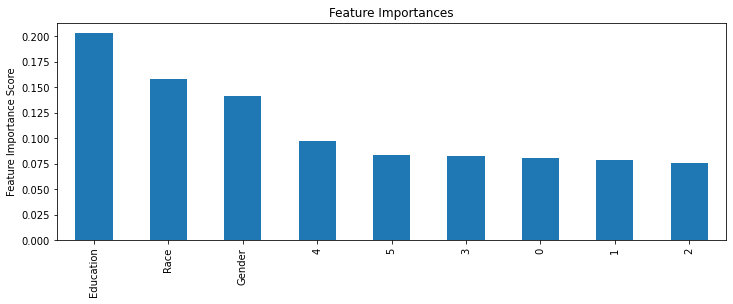

In [10]:
modelfit(xgb, X_train, y_train, X_test, y_test, performCV =False)

In [12]:
cm = sk.metrics.confusion_matrix(y_test,y_preds)
print(cm[0][0]/(cm[0][0] + cm[0][1]),cm[1][1]/(cm[1][0] + cm[1][1]))
cm

0.9076757917337628 0.8424731182795699


array([[1691,  172],
       [ 293, 1567]], dtype=int64)